## Time Series Classification using SigGPDE
_Dataset: PenDigits_

Before executing this notebook one should download the PenDigits dataset by doing

`cd benchmarks/datasets`

`bash download_data.sh`

***

In [1]:
# imports
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import sys
sys.path.append('..') 

# computations
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import gpflow as gp
import gpsig
import iisignature

# preprocessing, model evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# data loading
import requests, zipfile, io
from sktime.utils.load_data import load_from_arff_to_dataframe

Successfully loaded the Cuda PDE signature kernel operator


***
### Load dataset
Load a multivariate time series dataset (PenDigits) from timeseriesclassification.com

The dataset consists of 10 classes. Each example corresponds to a 2-dimensional curve followed by the hand while drawing a digit.

In [2]:
dataset_name = 'PenDigits'
dataset_url = 'https://timeseriesclassification.com/Downloads/{}.zip'.format(dataset_name)
  
X_train, y_train = load_from_arff_to_dataframe('../benchmarks/datasets/{0}/{0}_TRAIN.arff'.format(dataset_name))
X_test, y_test = load_from_arff_to_dataframe('../benchmarks/datasets/{0}/{0}_TEST.arff'.format(dataset_name))

***
### Format and preprocess data

In [3]:
labels_dict = {c : i for i, c in enumerate(np.unique(y_train))}
y_train = np.asarray([labels_dict[c] for c in y_train])
y_test = np.asarray([labels_dict[c] for c in y_test])

In [4]:
X_train = [np.stack(x, axis=1) for x in X_train.values]
X_test = [np.stack(x, axis=1) for x in X_test.values]

As preprocessing, we add a monotonically increasing coordinate with unit steps between time-observations, that we call "time". 

In [5]:
X_train = gpsig.preprocessing.add_time_to_list(X_train)
X_test = gpsig.preprocessing.add_time_to_list(X_test)

As we would like to have a validation set that we monitor while optimizing the hyperparameters of the model, we split the training data 80-20 in a stratified manner.

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train)

We also jointly normalize using the training set all channels to zero mean and unit variance.

In [7]:
scaler = StandardScaler()
scaler.fit(np.concatenate(X_train, axis=0))

X_train = [scaler.transform(x) for x in X_train]
X_val = [scaler.transform(x) for x in X_val]
X_test = [scaler.transform(x) for x in X_test]

In this dataset all time series happen to have the same length. If it were not the case, we would pad the sequences by repeating their last observation. This makes it possible to have a dataset in the form of a 3d tensor $[N,L,D]$ where $N$ is the number of sequences, $L$ their length, $D$ the number of channels. 

In [8]:
X_train = gpsig.preprocessing.tabulate_list_of_sequences(X_train)
X_val = gpsig.preprocessing.tabulate_list_of_sequences(X_val)
X_test = gpsig.preprocessing.tabulate_list_of_sequences(X_test)

100%|██████████| 3498/3498 [00:00<00:00, 56349.33it/s]


We plot a few digits

X_train shape: (5995, 8, 3)
y_train shape: (5995,)
X_val shape: (1499, 8, 3)
y_val shape: (1499,)
X_test shape: (3498, 8, 3)
y_test shape: (3498,)


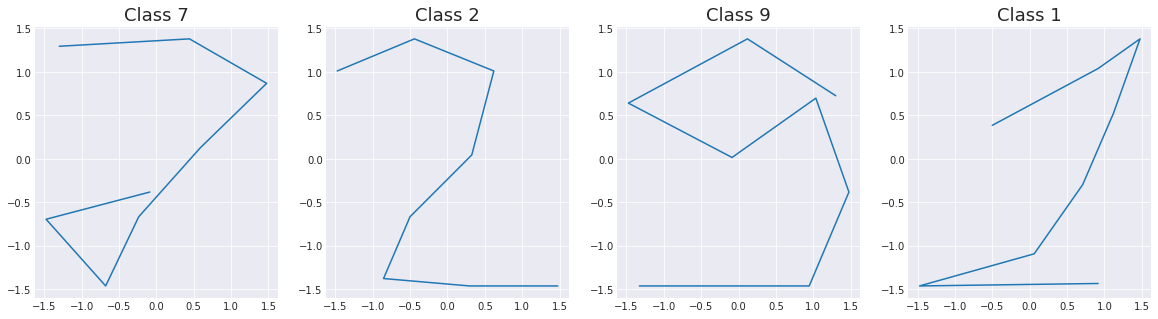

In [9]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].plot(X_train[0][:,1],X_train[0][:,2])
axes[0].set_title('Class {0}'.format(y_train[0]),fontsize=18)
axes[1].plot(X_train[1][:,1],X_train[1][:,2])
axes[1].set_title('Class {0}'.format(y_train[1]),fontsize=18)
axes[2].plot(X_train[2][:,1],X_train[2][:,2])
axes[2].set_title('Class {0}'.format(y_train[2]),fontsize=18)
axes[3].plot(X_train[3][:,1],X_train[3][:,2])
axes[3].set_title('Class {0}'.format(y_train[3]),fontsize=18)

plt.show()

***
### Setup the GP model

In [10]:
num_train, len_examples, num_features = X_train.shape
num_val = X_val.shape[0]
num_test = X_test.shape[0]
num_classes = np.unique(y_train).size

We are going to use $M=500$ inducing variables

In [11]:
num_inducing = 500

Here, because the dataset is of reasonable size, we chose to precompute the signatures that will be used in the sparse approximation. We will use the iisignature Python library. 
First we compute the truncation level required to ensure that we can get $M=500$ signature features.

In [12]:
trunc_level = gpsig.utils.compute_trunc(num_inducing,num_features)
print('Need to truncate at level {0} to precompute {1} inducing features'.format(trunc_level, num_inducing))

Need to truncate at level 6 to precompute 500 inducing features


In [13]:
S_train_ = iisignature.sig(X_train,trunc_level)
S_val_ = iisignature.sig(X_val,trunc_level)
S_test_ = iisignature.sig(X_test,trunc_level)

The first signature feature is always equal to $1$ and is not returned by iisignature. 

In [14]:
S_train = S_train_[:,:num_inducing-1]
S_val = S_val_[:,:num_inducing-1]
S_test = S_test_[:,:num_inducing-1]

To initialize the lengthscales we use a GPSig function such that $l_i^{(0)} := \sqrt{\mathbb{E}\vert x_i - \tilde{x}_i\vert^2\cdot d}$ for $i \in \{1, 2, \dots, d\}$ using $n = 1000$ randomly selected observation samples from the data.

In [ ]:
l_init = gpsig.utils.suggest_initial_lengthscales(X_train, num_samples=1000)

Since GPflow kernels usually expect as inputs numpy arrays in a 2d axis format, we flatten out the last two dimensions of the input arrays (which are then expanded again inside the kernel calculations).

In [16]:
input_dim = len_examples * num_features
X_train = X_train.reshape([-1, input_dim])
X_val = X_val.reshape([-1, input_dim]) if X_val is not None else None
X_test = X_test.reshape([-1, input_dim])

Next instantiate the different parts of the model.
***

We instantiate the class of inducing variables for the sparse approximation

In [17]:
feat = gpsig.inducing_variables_vosf.UntruncInducingOrthogonalTensors(input_dim=input_dim, d = num_features,
                                                                                              M=num_inducing)

In [18]:
order = 3
k = gpsig.kernels_pde.UntruncSignatureKernel(input_dim, num_features, order=order,lengthscales=l_init, 
                                                                                implementation='gpu_op')

In [19]:
if num_classes == 2:
    lik = gp.likelihoods.Bernoulli()
    num_latent = 1
else:
    lik = gp.likelihoods.MultiClass(num_classes)
    num_latent = num_classes

m = gpsig.models.SVGP(np.concatenate([X_train,S_train],axis=1), y_train[:, None], kern=k, feat=feat, likelihood=lik, num_latent=num_latent, minibatch_size=50)

***
### Train model using stochastic variational inference

Setup the metrics for training, for monitoring we look at the validation nlpp and the validation accuracy

In [20]:
acc = lambda m, X, y: accuracy_score(y, np.argmax(m.predict_y(X)[0], axis=1))
nlpp = lambda m, X, y: -np.mean(m.predict_density(X, y[:, None]))

val_acc = lambda m: acc(m, np.concatenate([X_val,S_val],axis=1), y_val)
val_nlpp = lambda m: nlpp(m, np.concatenate([X_val,S_val],axis=1), y_val)

test_acc = lambda m: acc(m, np.concatenate([X_test,S_test],axis=1), y_test)
test_nlpp = lambda m: nlpp(m, np.concatenate([X_test,S_test],axis=1), y_test)

opt = gpsig.training.NadamOptimizer # use Nadam optimizer i.e. Adam with Nesterov momentum

***
First, as usual, fix the kernel hyperparameters and train for a fixed number of iterations to tighten the ELBO bound.

In [21]:
# train model with kernel hyperparameters fixed
m.kern.set_trainable(False)
hist = gpsig.training.optimize(m, opt(1e-3), max_iter=5000, print_freq=100, save_freq=100, val_scorer=[val_acc, val_nlpp])

-------------------------
  Starting optimization  
-------------------------
Iteration 100	|	Time: 1.90	|	ELBO: -33314.99	|	Val. 0: 0.8746	|	Val. 1: 0.9120
Iteration 200	|	Time: 5.10	|	ELBO: -26206.14	|	Val. 0: 0.9053	|	Val. 1: 0.7564
Iteration 300	|	Time: 6.52	|	ELBO: -17298.10	|	Val. 0: 0.8612	|	Val. 1: 0.4659
Iteration 400	|	Time: 7.90	|	ELBO: -13049.24	|	Val. 0: 0.8699	|	Val. 1: 0.2971
Iteration 500	|	Time: 9.29	|	ELBO: -7469.37	|	Val. 0: 0.9333	|	Val. 1: 0.1705
Iteration 600	|	Time: 10.69	|	ELBO: -3807.91	|	Val. 0: 0.9553	|	Val. 1: 0.1292
Iteration 700	|	Time: 12.11	|	ELBO: -3251.14	|	Val. 0: 0.9586	|	Val. 1: 0.1215
Iteration 800	|	Time: 13.53	|	ELBO: -5642.31	|	Val. 0: 0.9613	|	Val. 1: 0.1105
Iteration 900	|	Time: 14.92	|	ELBO: -4140.08	|	Val. 0: 0.9640	|	Val. 1: 0.1016
Iteration 1000	|	Time: 16.31	|	ELBO: -3243.84	|	Val. 0: 0.9640	|	Val. 1: 0.1032
Iteration 1100	|	Time: 17.70	|	ELBO: -3918.50	|	Val. 0: 0.9680	|	Val. 1: 0.0957
Iteration 1200	|	Time: 19.09	|	ELBO: -2370.40	|	Val.

***
Second, unfix the kernel hyperparameters and train for 5000 more iterations.

In [22]:
# unfix kernel hyperparameters and train with early stopping with 5000 iterations patience
m.kern.set_trainable(True)
hist = gpsig.training.optimize(m, opt(1e-3), max_iter=5000, print_freq=100, save_freq=100, history=hist,
                               val_scorer=[val_acc, val_nlpp], save_best_params=True, lower_is_better=True)
m.assign(hist['best']['params'])

---------------------------
  Continuing optimization  
---------------------------
Iteration 5001	|	Time: 72.69	|	ELBO: -2226.65	|	Val. 0: 0.9847	|	Val. 1: 0.0566
Iteration 5100	|	Time: 74.47	|	ELBO: -2159.75	|	Val. 0: 0.9853	|	Val. 1: 0.0566
Iteration 5200	|	Time: 76.08	|	ELBO: -2095.44	|	Val. 0: 0.9860	|	Val. 1: 0.0580
Iteration 5300	|	Time: 77.67	|	ELBO: -4266.71	|	Val. 0: 0.9853	|	Val. 1: 0.0579
Iteration 5400	|	Time: 79.25	|	ELBO: -4586.48	|	Val. 0: 0.9840	|	Val. 1: 0.0578
Iteration 5500	|	Time: 80.86	|	ELBO: -5272.32	|	Val. 0: 0.9847	|	Val. 1: 0.0611
Iteration 5600	|	Time: 82.46	|	ELBO: -3013.33	|	Val. 0: 0.9840	|	Val. 1: 0.0621
Iteration 5700	|	Time: 84.06	|	ELBO: -2844.03	|	Val. 0: 0.9840	|	Val. 1: 0.0635
Iteration 5800	|	Time: 85.67	|	ELBO: -3242.18	|	Val. 0: 0.9827	|	Val. 1: 0.0655
Iteration 5900	|	Time: 87.26	|	ELBO: -3572.61	|	Val. 0: 0.9840	|	Val. 1: 0.0678
Iteration 6000	|	Time: 88.86	|	ELBO: -3459.99	|	Val. 0: 0.9847	|	Val. 1: 0.0651
Iteration 6100	|	Time: 90.46	|	ELBO:

***
Third, fix the kernel again and re-merge the validation set into the training data. Train for a fixed number of iterations to assimilate the remaining information into the variational approximation.

In [23]:
X_train, y_train = np.concatenate((np.concatenate([X_train,S_train],axis=1), np.concatenate([X_val,S_val],axis=1)), axis=0), np.concatenate((y_train, y_val), axis=0)

num_train = X_train.shape[0]
m.X, m.Y = X_train, y_train
m.num_data = num_train

m.kern.set_trainable(False)
hist = gpsig.training.optimize(m, opt(1e-3), max_iter=5000, print_freq=100, save_freq=100, history=hist)

---------------------------
  Continuing optimization  
---------------------------
Iteration 10100	|	Time: 154.50	|	ELBO: -2447.91
Iteration 10200	|	Time: 155.76	|	ELBO: -1934.89
Iteration 10300	|	Time: 157.02	|	ELBO: -4138.68
Iteration 10400	|	Time: 158.27	|	ELBO: -3065.79
Iteration 10500	|	Time: 159.53	|	ELBO: -2636.77
Iteration 10600	|	Time: 160.81	|	ELBO: -2925.43
Iteration 10700	|	Time: 162.07	|	ELBO: -2108.17
Iteration 10800	|	Time: 163.35	|	ELBO: -2936.96
Iteration 10900	|	Time: 164.61	|	ELBO: -2908.89
Iteration 11000	|	Time: 165.88	|	ELBO: -2565.43
Iteration 11100	|	Time: 167.14	|	ELBO: -3200.13
Iteration 11200	|	Time: 168.40	|	ELBO: -2187.12
Iteration 11300	|	Time: 169.66	|	ELBO: -1708.04
Iteration 11400	|	Time: 170.92	|	ELBO: -2771.04
Iteration 11500	|	Time: 172.17	|	ELBO: -2036.41
Iteration 11600	|	Time: 173.44	|	ELBO: -2630.49
Iteration 11700	|	Time: 174.72	|	ELBO: -2104.31
Iteration 11800	|	Time: 175.99	|	ELBO: -1890.43
Iteration 11900	|	Time: 177.28	|	ELBO: -1605.28
Iter

***
### Evaluate model performance

In [24]:
print('Test nlpp.: {:.03f}'.format(test_nlpp(m)))
print('Test acc.: {:.03f}'.format(test_acc(m)))
print('Test classification report:')
print(classification_report(y_test, np.argmax(m.predict_y(np.concatenate([X_test,S_test],axis=1))[0], axis=1)))

Test nlpp.: 0.089
Test acc.: 0.975
Test classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       363
           1       0.94      0.94      0.94       364
           2       0.96      1.00      0.98       364
           3       0.98      0.99      0.99       336
           4       1.00      0.98      0.99       364
           5       1.00      0.96      0.98       335
           6       1.00      0.97      0.98       336
           7       0.97      0.96      0.96       364
           8       0.95      0.99      0.97       336
           9       0.97      0.98      0.97       336

    accuracy                           0.97      3498
   macro avg       0.98      0.97      0.98      3498
weighted avg       0.98      0.97      0.97      3498



In [25]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/kern/lengthscales,Parameter,None,+ve,False,"(3,)",True,"[2.4134968404939907, 2.473604345777577, 2.4450..."
SVGP/kern/sigma,Parameter,None,+ve,False,(),True,1.0012013541297842
SVGP/likelihood/invlink/epsilon,Parameter,"Beta(0.2,5.0)","[0.0, 1.0]",False,(),True,0.0009999999999999996
SVGP/q_mu,Parameter,None,(none),True,"(500, 10)",True,"[[-0.3087749957831264, 0.01952889277460891, 0...."
SVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(10, 500, 500)",True,"[[[0.862757312710208, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### Inspect training curve

In [27]:
time = [y['time'] for x, y in hist.items() if str(x).isnumeric()]
elbo = [y['elbo'] for x, y in hist.items() if str(x).isnumeric()]
val_acc = [y['val'][0] for x, y in hist.items() if str(x).isnumeric() and 'val' in y]
val_nlpp = [y['val'][1] for x, y in hist.items() if str(x).isnumeric() and 'val' in y]

Text(0.5, 1.0, 'Validation nlpp. over time')

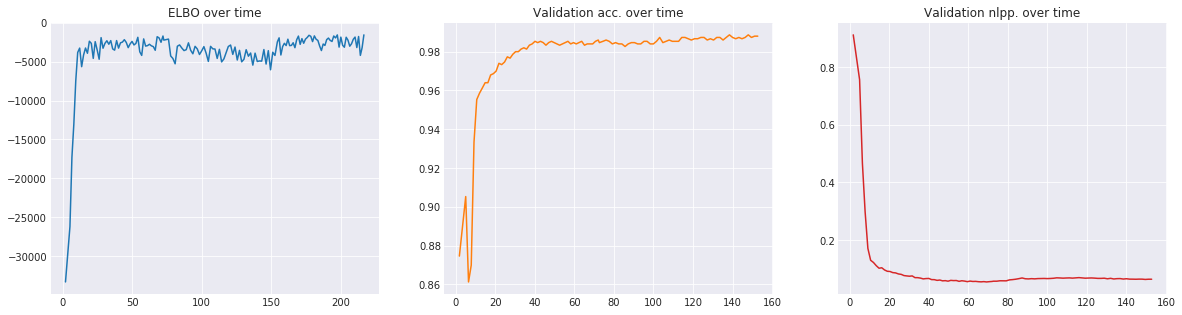

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].plot(time, elbo)
axes[0].set_title('ELBO over time')
axes[1].plot(time[:len(val_nlpp)], val_acc, 'tab:orange')
axes[1].set_title('Validation acc. over time')
axes[2].plot(time[:len(val_nlpp)], val_nlpp, 'tab:red')
axes[2].set_title('Validation nlpp. over time')